<a href="https://colab.research.google.com/github/lydyang/HMS-Classification/blob/main/Main_EEG_AIT_Data_Science_HMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HMS - Harmful Brain Activity Classification**
Shirui Li, Falak Pabari, Lydia Yang, Echo Zhang

Challenge found [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/overview).

The goal of this challenge is to classify patients data into one of six categories of harmful brain activity:
*   SZ - seizure (sudden, uncontrolled)
*   LPD - lateralized periodic discharges.
*   GPD - generalized periodic discharges
*   LRDA - lateralized rhythmic delta activity
*   GRDA - generalized rhythmic delta activity
*   Other

The dataset gives both EEG and Spectrogram data and we will use both types of data to develop two models to check which type of data will give us more accuracy.

NOTE: Due to the Google Colab RAM limits, we are only able to load either eeg or spectrogram and run the models. If you have more storage, you can choose to load more of the data in the code cell below. The outputs of the EEG model are here and the outputs of the Spectrogram model are in another notebook.

# **Data Preparation - EEG & Spectrogram**

In [ ]:
# Values to load the data
eeg_load = 0.3
spectrogram_load = 0.005

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import numpy as np
import tensorflow as tf
import opendatasets as od
import random
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import configparser
import cv2
from configparser import ConfigParser
from pathlib import Path

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, Conv1D, MaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

Input Kaggle username and API key when prompted:

username: "lydddddd"
password: "2ee9d5fcab6a9b81550b85c8d408d476"

In [ ]:
dataset = 'https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/data'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lydddddd
Your Kaggle Key: ··········


100%|██████████| 18.4G/18.4G [03:04<00:00, 107MB/s] 



Extracting archive ./hms-harmful-brain-activity-classification/hms-harmful-brain-activity-classification.zip to ./hms-harmful-brain-activity-classification


In [ ]:
data_dir = './hms-harmful-brain-activity-classification'

In [ ]:
# Source: https://www.geeksforgeeks.org/python-get-unique-values-list/
def unique(list1):

    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return unique_list

In [ ]:
# Retrieve id names in a list for correlation
# id list format: eeg_id, spectrogram_id, patient_id, consensus
label_mapping = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}

train_csv = pd.read_csv(data_dir + '/train.csv')

eegids = train_csv['eeg_id'].tolist()
spectids = train_csv['spectrogram_id'].tolist()
patientids = train_csv['patient_id'].tolist()
consensus = [label_mapping[x] for x in train_csv['expert_consensus'].tolist()]
ids = unique(list(zip(eegids, spectids, patientids, consensus)))

In [ ]:
# Extract x and y datatet for spectrograms
rand_spectrogram = random.sample(ids, int(spectrogram_load*len(ids)))
spectrogram_dir = [(data_dir+"/"+"train_eegs/"+str(x[0])+".parquet") for x in rand_spectrogram]
x_spectrogram = [pd.read_parquet(file) for file in spectrogram_dir]
y_spectrogram = [x[3] for x in rand_spectrogram]
x_spectrogram[0]

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,34843.738281,1583.869995,-5224.790039,630.039978,554.539978,-3043.850098,6059.529785,7211.410156,3394.229980,-2029.150024,904.119995,5453.680176,4379.689941,-1351.260010,1970.400024,2977.659912,-1713.599976,-5411.680176,-3213.989990,44.930000
1,34843.738281,1575.890015,-5207.509766,628.179993,550.289978,-3033.750000,6042.250000,7190.140137,3382.530029,-2019.579956,903.049988,5432.680176,4368.000000,-1344.609985,1968.800049,2968.090088,-1708.550049,-5391.470215,-3201.500000,55.560001
2,34843.738281,1564.989990,-5189.970215,625.520020,545.770020,-3022.320068,6024.970215,7169.399902,3366.320068,-2010.270020,900.659973,5402.370117,4352.839844,-1338.500000,1965.880005,2956.919922,-1701.099976,-5371.000000,-3189.000000,52.099998
3,34843.738281,1563.930054,-5174.279785,623.130005,544.440002,-3014.080078,6006.890137,7147.600098,3358.610107,-2003.359985,896.409973,5394.399902,4339.020020,-1336.640015,1956.310059,2943.370117,-1700.569946,-5355.319824,-3181.560059,42.000000
4,34843.738281,1558.079956,-5160.729980,619.140015,543.109985,-3004.239990,5987.479980,7121.020020,3348.770020,-2002.829956,891.619995,5382.700195,4324.399902,-1336.900024,1948.599976,2931.669922,-1698.979980,-5338.839844,-3173.580078,51.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18395,15.950000,-32.430000,-72.040001,-11.960000,-35.360001,-22.600000,-26.580000,31.370001,35.619999,-2.660000,67.260002,8.240000,12.230000,35.360001,32.169998,45.189999,18.080000,38.009998,61.939999,13.290000
18396,35.090000,-23.930000,-69.650002,-10.370000,-32.700001,-18.080000,-27.650000,29.510000,49.980000,7.980000,68.050003,27.910000,23.930000,38.279999,31.629999,53.970001,17.809999,36.689999,60.610001,7.710000
18397,18.080000,-30.840000,-72.839996,-13.030000,-36.419998,-17.010000,-29.510000,27.910000,38.549999,-2.920000,64.330002,13.030000,18.610001,33.759998,28.180000,46.520000,15.680000,35.360001,57.950001,11.970000
18398,11.170000,-33.230000,-73.110001,-13.820000,-38.549999,-21.799999,-30.309999,25.790001,34.029999,-6.380000,61.939999,6.110000,19.940001,34.029999,26.320000,48.380001,19.410000,35.360001,56.889999,0.270000


In [ ]:
rand_eeg = random.sample(ids, int(eeg_load*len(ids)))
eeg_dir = [(data_dir+"/"+"train_eegs/"+str(x[0])+".parquet") for x in rand_eeg]
x_eeg = [pd.read_parquet(file) for file in eeg_dir]
y_eeg = [x[3] for x in rand_eeg]
x_eeg[0]

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-8.470000,-28.389999,-3.950000,2.180000,-7.250000,-12.790000,17.580000,6.880000,-2.100000,31.440001,3.670000,-38.250000,-30.410000,4.350000,26.100000,-19.820000,-33.840000,32.590000,21.480000,39.340000
1,-7.390000,-33.459999,-16.910000,-13.120000,-14.430000,-27.629999,3.650000,2.580000,-5.670000,23.400000,3.110000,-33.990002,-11.540000,-3.030000,29.250000,-26.860001,-44.959999,13.750000,5.520000,91.959999
2,-20.580000,-57.369999,-37.500000,-41.349998,-32.950001,-51.770000,-23.410000,-28.219999,-25.500000,-4.460000,-37.230000,-52.330002,-78.220001,-19.920000,0.830000,-45.040001,-66.180000,-16.160000,-20.219999,43.869999
3,-6.330000,-36.950001,-14.490000,-10.880000,-12.610000,-22.719999,4.900000,-5.750000,-6.910000,18.190001,-15.890000,-36.680000,-45.450001,-4.290000,9.420000,-22.270000,-39.200001,19.600000,4.300000,20.350000
4,-0.360000,-30.020000,-11.190000,-3.210000,-7.220000,-15.010000,12.420000,8.230000,-0.940000,24.830000,2.200000,-24.230000,-3.380000,-6.820000,19.430000,-16.790001,-33.950001,23.469999,6.670000,83.519997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12395,39.720001,12.870000,-2.020000,-26.580000,10.630000,-18.660000,-17.459999,-18.049999,40.770000,33.869999,-14.140000,10.360000,1.450000,-1.870000,-3.480000,-0.340000,-37.180000,-7.230000,-29.070000,52.060001
12396,21.670000,-6.420000,-13.450000,-43.009998,-5.160000,-34.110001,-31.740000,-40.029999,22.139999,12.920000,-47.020000,-10.170000,-61.529999,-16.650000,-31.549999,-11.520000,-49.650002,-22.840000,-44.840000,-11.230000
12397,32.470001,14.240000,10.690000,-6.890000,13.320000,-0.910000,1.400000,-8.440000,40.889999,39.790001,-13.810000,7.170000,-7.250000,1.680000,-12.390000,16.709999,-15.920000,18.709999,-13.970000,-14.480000
12398,17.160000,-2.690000,-4.540000,-18.410000,-4.520000,-16.330000,-8.240000,-9.590000,24.670000,29.030001,-10.560000,-0.330000,3.070000,-7.650000,-5.500000,7.690000,-21.870001,7.950000,-19.260000,37.419998


In [ ]:
def get_array_1stdim(train_datatype):
  '''Get the first dimension data into an array. train_datatype should be egg or spectrogram'''
  list_1stdim = []

  for elem in train_datatype:
    list_1stdim.append(elem.shape[0])

  return np.array(list_1stdim)

In [ ]:
# Histogram
def get_array_1stdim(train_datatype):
  '''Get the first dimension data into an array. train_datatype should be egg or spectrogram'''
  list_1stdim = []

  for elem in train_datatype:
    list_1stdim.append(elem.shape[0])

  return np.array(list_1stdim)

def make_hist(array_1stdim, title):
  '''Plotting a histogram of the first dim data'''
  plt.hist(array_1stdim, bins=100, range=[0, 12000], color='skyblue', edgecolor='black')
  # plt.hist(array_1stdim, bins=100, color='skyblue', edgecolor='black')

  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title('Distribution of the First Dimension ' + title)

  plt.show()

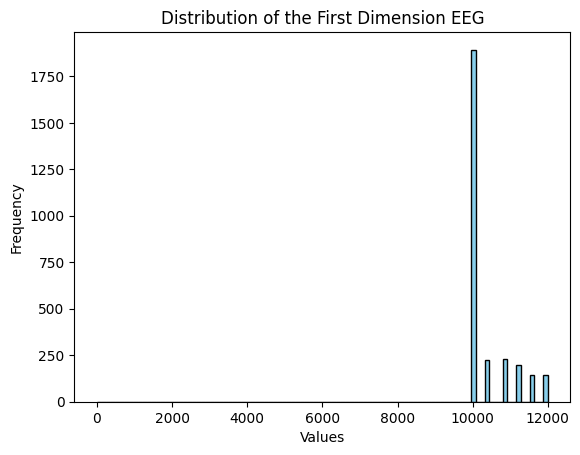

In [ ]:
make_hist(get_array_1stdim(x_eeg), "EEG")

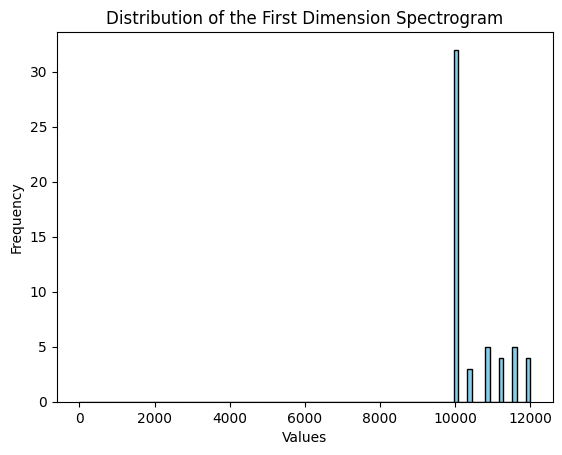

In [ ]:
make_hist(get_array_1stdim(x_spectrogram), "Spectrogram")

In [ ]:
def trim(value, x, y):
  new_x = []
  new_y = []

  # make new train
  for i in range(len(x)):
    if x[i].shape[0] <= value:
      new_x.append(x[i])
      new_y.append(y[i])

  return new_x, new_y

In [ ]:
x_eeg, y_eeg = trim(10000, x_eeg, y_eeg)

In [ ]:
print(x_eeg[0], y_eeg[0])

            Fp1         F3     C3         P3         F7         T3         T5  \
0     14.410000 -22.420000  -9.53 -16.620001  11.220000  -2.800000  10.180000   
1      7.460000 -29.080000 -15.01 -22.950001   2.780000  -8.290000   3.400000   
2     18.910000 -20.370001 -12.10 -16.370001  14.650000  -5.290000   7.410000   
3     18.129999 -19.469999  -9.61 -15.630000  14.980000  -3.340000   9.600000   
4      7.140000 -27.959999 -14.49 -22.660000   3.570000  -7.960000   3.500000   
...         ...        ...    ...        ...        ...        ...        ...   
9995  -1.890000 -29.610001  10.04  30.000000  -6.570000  -7.910000  34.189999   
9996 -14.930000 -38.950001   3.87  21.400000 -19.530001 -15.330000  26.730000   
9997  -7.380000 -35.299999   2.96  21.049999 -12.440000 -16.100000  26.549999   
9998  -4.520000 -30.420000   6.02  20.910000  -8.290000 -13.290000  28.770000   
9999 -16.780001 -40.860001  -2.67   7.060000 -22.209999 -21.299999  17.580000   

             O1     Fz     

In [ ]:
print(len(x_eeg))

1882


In [ ]:
x_spectrogram, y_spectrogram = trim(10000, x_spectrogram, y_spectrogram)

# **Splitting Train-Test Dataset - EEG**

In [ ]:
for L in x_eeg:
  L.fillna(0,inplace=True)

In [ ]:
train_ratio  = 0.8
train_length = len(x_eeg) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
temp_x_train_eeg, temp_y_train_eeg = x_eeg[:train_split], y_eeg[:train_split]
print(len(temp_x_train_eeg), len(temp_y_train_eeg))
x_test_eeg, y_test_eeg = x_eeg[train_split:], y_eeg[train_split:]
print(len(x_test_eeg), len(y_test_eeg))

1882
1505
1505 1505
377 377


In [ ]:
train_ratio  = 0.8
train_length = len(temp_x_train_eeg) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
x_train_eeg, y_train_eeg = temp_x_train_eeg[:train_split], temp_y_train_eeg[:train_split]
print(len(x_train_eeg), len(y_train_eeg))
x_valid_eeg, y_valid_eeg = temp_x_train_eeg[train_split:], temp_y_train_eeg[train_split:]
print(len(x_valid_eeg), len(y_valid_eeg))

1505
1204
1204 1204
301 301


In [ ]:
x_valid_eeg[0]

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,11.59,4.18,-3.30,-3.50,22.969999,13.180000,-1.47,4.300000,-15.12,-5.92,-8.070000,-3.80,-9.58,-17.559999,-3.02,-13.120000,3.15,-6.000000,3.650000,-0.010000
1,13.88,8.10,2.97,-0.10,18.980000,13.310000,1.03,8.420000,-12.56,-1.95,-6.890000,-2.04,-9.01,-20.580000,-5.40,-12.040000,-5.16,-8.880000,5.260000,1.460000
2,10.60,3.63,-5.73,-5.18,23.840000,5.940000,-9.26,-28.299999,-15.30,-3.94,-7.480000,-3.64,-6.87,-10.790000,-2.03,-23.049999,-11.88,-5.290000,-3.900000,19.240000
3,21.00,18.48,8.30,5.41,30.160000,8.590000,2.62,2.330000,-2.00,11.20,5.390000,6.16,5.22,-2.980000,8.96,-1.090000,6.32,1.140000,13.500000,43.119999
4,13.08,3.66,-9.21,-15.51,26.250000,2.760000,-8.66,-1.360000,-13.62,-5.32,-17.559999,-3.40,-4.91,-20.030001,-11.64,-7.670000,-7.14,-13.080000,-10.380000,25.760000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-6.55,-15.10,-6.66,-7.88,-18.580000,-1.520000,-4.40,7.680000,-14.26,-11.01,-6.280000,-13.98,-11.05,-15.010000,-11.11,-14.390000,-9.86,-12.470000,7.600000,-30.200001
9996,13.08,6.28,6.96,6.64,-6.200000,-1.970000,-0.59,-13.030000,-1.57,2.31,10.080000,12.03,4.35,4.610000,12.09,-5.370000,5.99,19.790001,37.220001,-20.410000
9997,5.33,-11.13,1.03,-2.43,-0.210000,-9.140000,-3.51,-5.210000,-7.66,-3.38,2.780000,13.85,4.71,-5.590000,5.63,5.040000,9.99,9.110000,20.330000,-15.160000
9998,-9.89,-4.55,-10.23,-16.09,-15.060000,-19.030001,-2.16,17.660000,-9.44,-9.04,-3.150000,3.70,2.62,-8.220000,0.37,4.370000,6.48,5.800000,21.480000,-23.010000


In [ ]:
x_train_eeg = np.array(x_train_eeg)
x_test_eeg = np.array(x_test_eeg)
x_valid_eeg = np.array(x_valid_eeg)

y_train_eeg = np.array(y_train_eeg)
y_test_eeg = np.array(y_test_eeg)
y_valid_eeg = np.array(y_valid_eeg)

In [ ]:
mean = x_train_eeg.mean(axis=0)
std  = x_train_eeg.std(axis=0)
x_train_eeg = (x_train_eeg-mean)/std
x_valid_eeg = (x_valid_eeg-mean)/std
x_test_eeg  = (x_test_eeg-mean)/std

In [ ]:
print(mean,std)

[[207.3455    176.20868   157.59987   ... 142.49452   132.41951
   63.431965 ]
 [178.06122   132.35307    96.76392   ...  80.55476   117.30495
   -1.7935771]
 [205.26445   164.26596   141.1319    ... 144.2856    166.17372
   30.358067 ]
 ...
 [106.183334   86.38317    63.723637  ... 121.15852    80.65953
  107.40106  ]
 [148.22394    73.21596    67.526276  ... 112.53884    94.68927
   43.229424 ]
 [150.33496   139.94052   102.6425    ... 106.33961    94.93149
   43.052254 ]] [[2209.5688 2059.6548 1994.7501 ... 1711.351  1976.3656 1982.7502]
 [2274.5488 1783.0271 1712.6877 ... 1436.9897 1801.7368 2352.1025]
 [2211.6384 1751.8279 1704.3922 ... 1379.3594 1524.0497 1604.8749]
 ...
 [1912.7913 1886.1792 1545.1134 ... 1831.6779 1872.8982 2211.9568]
 [1929.0334 1695.0394 1591.6241 ... 1871.3303 1912.4066 2071.5576]
 [1963.6304 1904.7374 1560.0568 ... 1578.3151 1628.1019 1444.8071]]


In [ ]:
thing = y_train_eeg.tolist()
values, counts = np.unique(thing, return_counts=True)
print(list(zip(values, counts)))

[0 1 2 3 4 5]
[ 83 153 145  40  94 689]


In [ ]:
nb_classes = len(np.unique(y_train_eeg))
print(nb_classes)
y_train_eeg = to_categorical(y_train_eeg, nb_classes)
y_valid_eeg = to_categorical(y_valid_eeg, nb_classes)
y_test_eeg  = to_categorical(y_test_eeg, nb_classes)

6


# **Training the Model - EEG**

In [ ]:
x_train_eeg.shape

(1204, 10000, 20)

In [ ]:
y_train_eeg.shape

(1204, 6)

In [ ]:
# Early Stopping Method
es = EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights=True)
rate = 0.1

In [ ]:
nb_filter       = 3   # number of filter/kernels in the convolutional layers
filter_length   = 48  # length of the filter/kernel in the convolutional layers
window_size     = x_train_eeg.shape[1] # the window size defined by the dataset
nb_features     = x_train_eeg.shape[2] # the number of features of the input data (number of dimensions)
nb_outputs      = y_train_eeg.shape[1] # the number of outputs (defined by the target data)

In [ ]:
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid"))
model.add(Dropout(rate))

# Second convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Third convolutional block (additional layer)
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(rate))
model.add(Dense(nb_outputs, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 9953, 9)           8649      
                                                                 
 batch_normalization_15 (Ba  (None, 9953, 9)           36        
 tchNormalization)                                               
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 4976, 9)           0         
 ng1D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 4976, 9)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, 4929, 3)           1299      
                                                                 
 batch_normalization_16 (Ba  (None, 4929, 3)          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
network_history = model.fit(x_train_eeg, y_train_eeg,
                            validation_data=(x_valid_eeg,y_valid_eeg),
                            batch_size=16,
                            epochs=100,
                            verbose=1,
                            callbacks=[es])

Epoch 1/100
76/76 [==============================] - 6s 35ms/step - loss: 4.9459 - accuracy: 0.4551 - val_loss: 4.1661 - val_accuracy: 0.4817
Epoch 2/100
76/76 [==============================] - 2s 21ms/step - loss: 3.7883 - accuracy: 0.5349 - val_loss: 3.9494 - val_accuracy: 0.4751
Epoch 3/100
76/76 [==============================] - 2s 23ms/step - loss: 3.3019 - accuracy: 0.5573 - val_loss: 3.6295 - val_accuracy: 0.5449
Epoch 4/100
76/76 [==============================] - 2s 21ms/step - loss: 2.7863 - accuracy: 0.5939 - val_loss: 2.9960 - val_accuracy: 0.5183
Epoch 5/100
76/76 [==============================] - 2s 21ms/step - loss: 2.4480 - accuracy: 0.6113 - val_loss: 3.4214 - val_accuracy: 0.5482
Epoch 6/100
76/76 [==============================] - 2s 23ms/step - loss: 2.2456 - accuracy: 0.6686 - val_loss: 3.6002 - val_accuracy: 0.4884
Epoch 7/100
76/76 [==============================] - 2s 28ms/step - loss: 2.1637 - accuracy: 0.6703 - val_loss: 2.7026 - val_accuracy: 0.5183
Epoch 

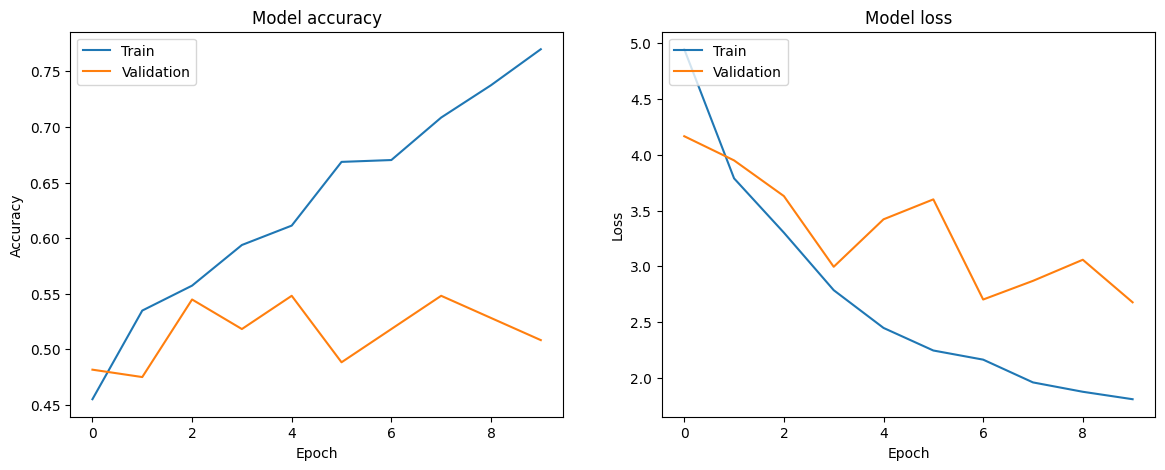

In [ ]:
# Assuming 'history' is the variable that holds the training history
history = network_history

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# **Evaluation - EEG**

In [ ]:
x_test_eeg.shape

(377, 10000, 20)

In [ ]:
y_test_eeg.shape

(377, 6)

In [ ]:
eval = model.evaluate(x_test_eeg,y_test_eeg)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

12/12 [==============================] - 0s 21ms/step - loss: 2.9321 - accuracy: 0.6313
Test loss: 2.9320952892303467
Test accuracy: 0.6312997341156006


In [ ]:
preds = model.predict(x_test_eeg)

12/12 [==============================] - 1s 25ms/step


In [ ]:
print(classification_report(np.argmax(y_test_eeg,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.25      0.09      0.13        23
           1       0.29      0.05      0.08        42
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        24
           5       0.66      0.93      0.77       252

    accuracy                           0.63       377
   macro avg       0.20      0.18      0.16       377
weighted avg       0.49      0.63      0.53       377



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
balanced_accuracy_score(np.argmax(y_test_eeg,1),np.argmax(preds,1))

0.17719116632160112

<Axes: >

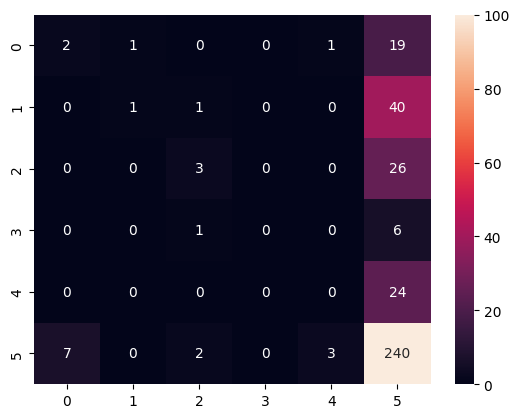

In [ ]:
conf=confusion_matrix(np.argmax(y_test_eeg,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

# **Splitting Train-Test Dataset - Spectrogram**

In [ ]:
for L in x_spectrogram:
  L.fillna(0,inplace=True)

In [ ]:
train_ratio  = 0.8
train_length = len(x_spectrogram) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
temp_x_train_spectrogram, temp_y_train_spectrogram = x_spectrogram[:train_split], y_spectrogram[:train_split]
print(len(temp_x_train_spectrogram), len(temp_y_train_spectrogram))
x_test_spectrogram, y_test_spectrogram = x_spectrogram[train_split:], y_spectrogram[train_split:]
print(len(x_test_spectrogram), len(y_test_spectrogram))

39
31
31 31
8 8


In [ ]:
train_ratio  = 0.8
train_length = len(temp_x_train_spectrogram) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
x_train_spectrogram, y_train_spectrogram = temp_x_train_spectrogram[:train_split], temp_y_train_spectrogram[:train_split]
print(len(x_train_spectrogram), len(y_train_spectrogram))
x_valid_spectrogram, y_valid_spectrogram = temp_x_train_spectrogram[train_split:], temp_y_train_spectrogram[train_split:]
print(len(x_valid_spectrogram), len(y_valid_spectrogram))

31
24
24 24
7 7


In [ ]:
x_train_spectrogram = np.array(x_train_spectrogram)
x_test_spectrogram = np.array(x_test_spectrogram)
x_valid_spectrogram = np.array(x_valid_spectrogram)

y_train_spectrogram = np.array(y_train_spectrogram)
y_test_spectrogram = np.array(y_test_spectrogram)
y_valid_spectrogram = np.array(y_valid_spectrogram)

In [ ]:
thing = y_train_spectrogram.tolist()
values, counts = np.unique(thing, return_counts=True)
print(list(zip(values, counts)))

In [ ]:
# nb_classes = len(np.unique(y_train_spectrogram))
nb_classes = 6
print(nb_classes)
y_train_spectrogram = to_categorical(y_train_spectrogram, nb_classes)
y_valid_spectrogram = to_categorical(y_valid_spectrogram, nb_classes)
y_test_spectrogram  = to_categorical(y_test_spectrogram, nb_classes)

6


# **Training the Model - Spectrogram**

In [ ]:
x_train_spectrogram.shape

(24, 10000, 20)

In [ ]:
y_train_spectrogram.shape

(24, 6)

In [ ]:
# Early Stopping Method
es = EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights=True)
rate = 0.1

In [ ]:
nb_filter       = 3   # number of filter/kernels in the convolutional layers
filter_length   = 5  # length of the filter/kernel in the convolutional layers
window_size     = x_train_spectrogram.shape[1] # the window size defined by the dataset
nb_features     = x_train_spectrogram.shape[2] # the number of features of the input data (number of dimensions)
nb_outputs      = y_train_spectrogram.shape[1] # the number of outputs (defined by the target data)

In [ ]:
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid"))
model.add(Dropout(rate))

# Second convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Third convolutional block (additional layer)
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(rate))
model.add(Dense(nb_outputs, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 9953, 9)           8649      
                                                                 
 batch_normalization_12 (Ba  (None, 9953, 9)           36        
 tchNormalization)                                               
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 4976, 9)           0         
 ng1D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 4976, 9)           0         
                                                                 
 conv1d_13 (Conv1D)          (None, 4929, 9)           3897      
                                                                 
 batch_normalization_13 (Ba  (None, 4929, 9)          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
network_history = model.fit(x_train_spectrogram, y_train_spectrogram,
                            validation_data=(x_valid_spectrogram, y_valid_spectrogram),
                            batch_size=16,
                            epochs=100,
                            verbose=1,
                            callbacks=[es])

Epoch 1/100
2/2 [==============================] - 3s 326ms/step - loss: 7.5503 - accuracy: 0.3750 - val_loss: 12.8861 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 0s 54ms/step - loss: 3.9606 - accuracy: 0.6250 - val_loss: 10.2035 - val_accuracy: 0.4286
Epoch 3/100
2/2 [==============================] - 0s 47ms/step - loss: 3.9892 - accuracy: 0.5417 - val_loss: 11.2275 - val_accuracy: 0.4286
Epoch 4/100
2/2 [==============================] - 0s 42ms/step - loss: 4.4967 - accuracy: 0.6667 - val_loss: 9.7665 - val_accuracy: 0.4286
Epoch 5/100
2/2 [==============================] - 0s 42ms/step - loss: 4.1105 - accuracy: 0.7083 - val_loss: 8.7723 - val_accuracy: 0.4286
Epoch 6/100
2/2 [==============================] - 0s 45ms/step - loss: 3.9807 - accuracy: 0.7083 - val_loss: 8.1617 - val_accuracy: 0.4286
Epoch 7/100
2/2 [==============================] - 0s 59ms/step - loss: 3.7245 - accuracy: 0.8333 - val_loss: 7.7684 - val_accuracy: 0.2857


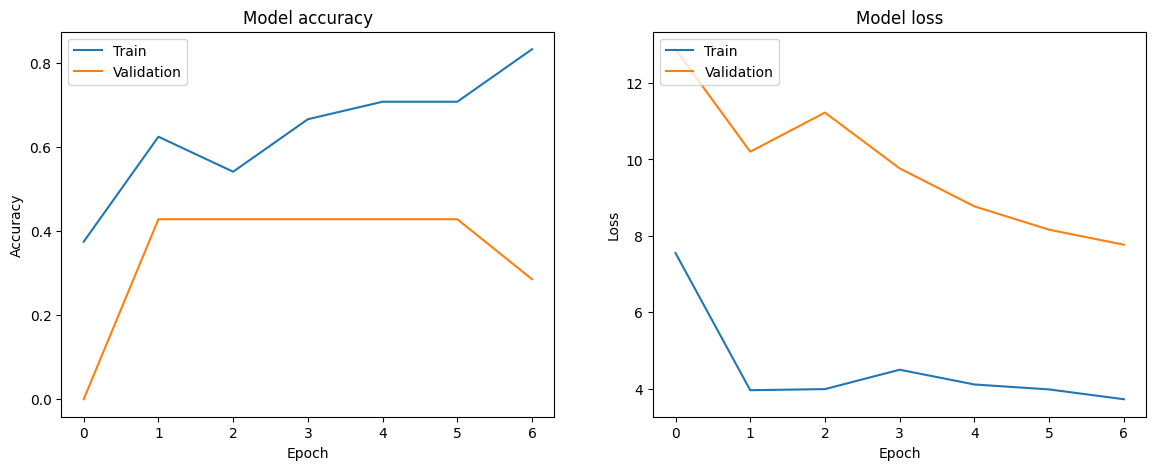

In [ ]:
# Assuming 'history' is the variable that holds the training history
history = network_history

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# **Evaluation - Spectrogram**

In [ ]:
x_test_spectrogram.shape

(7, 10000, 20)

In [ ]:
y_test_spectrogram.shape

(7, 6)

In [ ]:
eval = model.evaluate(x_test_spectrogram,y_test_spectrogram)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

1/1 [==============================] - 0s 165ms/step - loss: 5.5685 - accuracy: 0.2857
Test loss: 5.5685014724731445
Test accuracy: 0.2857142984867096


In [ ]:
preds = model.predict(x_test_spectrogram)

1/1 [==============================] - 0s 140ms/step


In [ ]:
print(classification_report(np.argmax(y_test_spectrogram,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           1       0.17      1.00      0.29         1
           2       0.00      0.00      0.00         1
           5       1.00      0.20      0.33         5

    accuracy                           0.29         7
   macro avg       0.39      0.40      0.21         7
weighted avg       0.74      0.29      0.28         7



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
balanced_accuracy_score(np.argmax(y_test_spectrogram,1),np.argmax(preds,1))

0.39999999999999997

<Axes: >

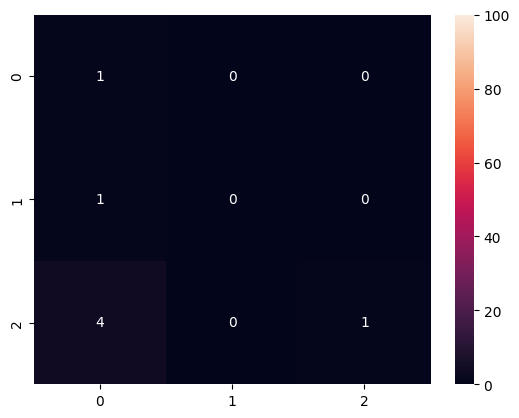

In [ ]:
conf=confusion_matrix(np.argmax(y_test_spectrogram,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)